## Project Overview

### Project Goal
The tech mental health survey used within this project was offered from 2014-2019, excluding the year 2015. Our department believes that there a good business case to resume this survey beginning next year, so you have been tasked with performing exploratory data analysis on historical data within our databases so that we can redesign the survey to resume industry research later this year. 

### Investigative Approach
We will investigate the findings of this multi-year survey through the lens of how to revamp it to be more statistically rigorous, more dense with insights, and more useful for our goal of answering the following research questions. 

### Key research questions
- Are tech workers more likely than other workers to have mental health problems? 
- Do tech workers have mental health resources available, and if so do they use them? 
- Do workers trust that their privacy will be protected? Do they fear career reprisals?
- Do they feel that mental health is valued in their workplace? 

## TL,DR

### Conclusions
Going through the survey questions corresponding to these 4 research questions, we can see that we are only able to glean incomplete insights from our current survey data, do to the structure of the survey and the biased nature of our sampling. These two features will have to be fixed before relaunching the survey this year. 

### Recommendations
1. Previous survey years were too biased, and need to be reworked to more accurately represent worker pools in both tech and non-tech industries
     - United States is overrepresented, as is California
     - White workers are overrepresented, as are men
     - Tech companies are overrepresented, and it is unclear what kinds of non-tech companies are being included. <br><br>
2. Questions need to be worded better to decouple sentiments toward working, managerial concerns, and professional/social worries.<br><br>
3. Questions need to be introduced to capture remote and hybrid work as well as traditional, in-office work.<br><br>
4. "Tech worker" needs to be defined for the purposes of this survey<br>
     - Are contract workers and full-time workers considered equally?<br>
     - Are both technical and non-technical roles sampled equally?<br>
     - What non-tech industries are being used as analogues? <br>

# Initial Setup

In [1]:
import os
import warnings
import os

os.chdir("/Users/lemuelrobinson/Documents/Turing_College/2_Sprint_1_Mental_Health")
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import re

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Set some printing style parameters
palette = sns.color_palette("bright")
# sns.set_palette("bright")

pd.set_option("display.max_colwidth", None)

# Create a connection object for the database
conn = sqlite3.connect("mental_health.sqlite")

# Create a cursor object
cursor = conn.cursor()

# An initial look

How many questions are in the survey each year?

In [ ]:
pd.read_sql(
    "SELECT COUNT(DISTINCT q.QuestionID) As '# of Questions' FROM Question q",
    conn,
)

,# of Questions
0,105


Are the same questions asked each year? 

In [ ]:
query = """
SELECT
    questionid,
    GROUP_CONCAT(DISTINCT surveyid) AS years_asked,
    COUNT(DISTINCT surveyid) AS number_of_years
FROM 
    answer
GROUP BY 
    questionid
"""
df = pd.read_sql(query, conn)

No, the first 12 questions are asked each year, of the survey, with new swaths of questions being added each year. Beyond some of the initial questions like age, country of residence, most questions won't have extensibility across all years of the survey, which will be hard to manage. 

What is the age breakdown of survey responders? 

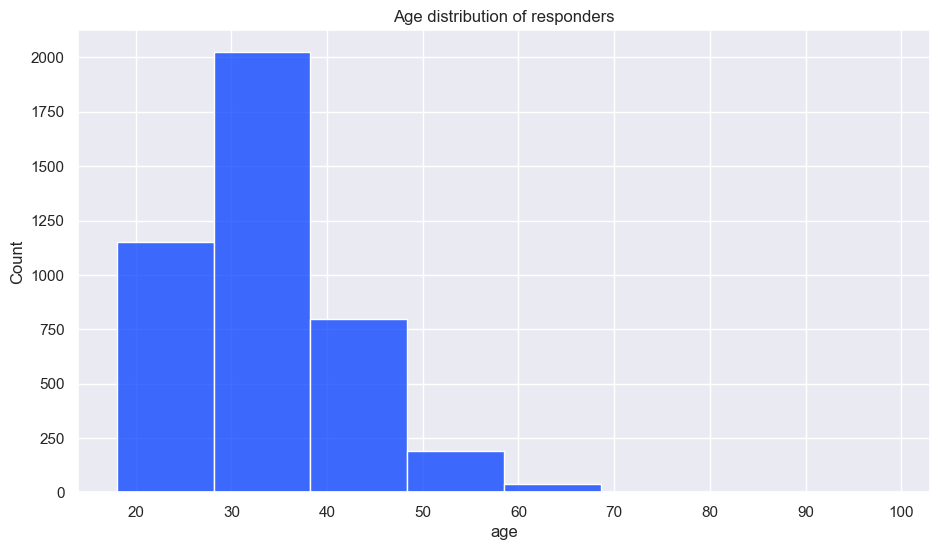

,Mean Age,Median Age
0,34,33


In [ ]:
ages = pd.read_sql(
    "SELECT answertext age FROM ANSWER WHERE questionid=1",
    conn,
)
# Convert ages to integers
ages.age = ages.age.map(lambda x: int(x))
ages.sort_values(by="age", inplace=True)

# Drop values that don't make sense
ages = ages.loc[ages.age >= 18]
ages = ages.loc[ages.age <= 100]

#Plot
sns.histplot(data=ages,x='age',binwidth=10);
plt.title('Age distribution of responders')
plt.show()

#Print dataframe with mean and median ages
pd.DataFrame({'Mean Age': [int(round(ages['age'].mean()))], 'Median Age': [int(ages['age'].median())]})

What is the gender breakdown of responders across the years of the survey? 

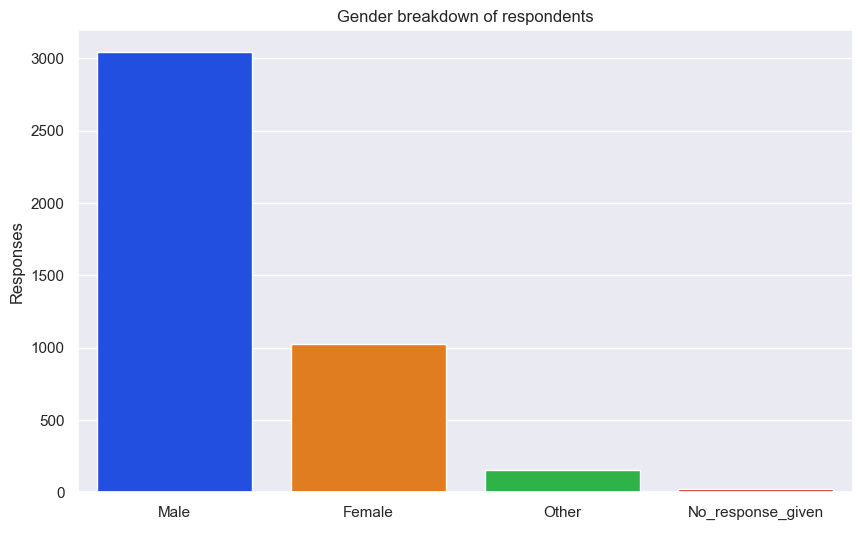

In [ ]:
gender = pd.read_sql(
    """
SELECT COUNT(CASE WHEN LOWER(answertext)='male' THEN 1 END) Male, 
    COUNT(CASE WHEN LOWER(answertext)='female' THEN 1 END) Female, 
    COUNT(CASE WHEN (LOWER(answertext)<>'female' AND LOWER(answertext)<>'male') THEN 1 END) Other,
    COUNT(CASE WHEN answertext=-1 THEN 1 END) No_response_given 
FROM 
    ANSWER 
WHERE 
    questionid=2
""",
    conn,
)

# Transpose the DataFrame for easier plotting
gender = gender.T.reset_index()

# Rename columns for better visualization
gender.columns = ['Category', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=gender,
            hue='Category', palette=palette);
plt.title('Gender breakdown of respondents');
plt.xlabel(' ');
plt.ylabel('Responses');
plt.show();

An important not here is that the dataset includes nonbinary, trans, and other identities in addition to joke responses. I condensed all gender non-conforming or non-binary responses into other along with "non serious" responses, not to trivialize other genders, but to refrain from ascribing intentions or interpretations to the answers given.

What is the racial background of survey responders? 

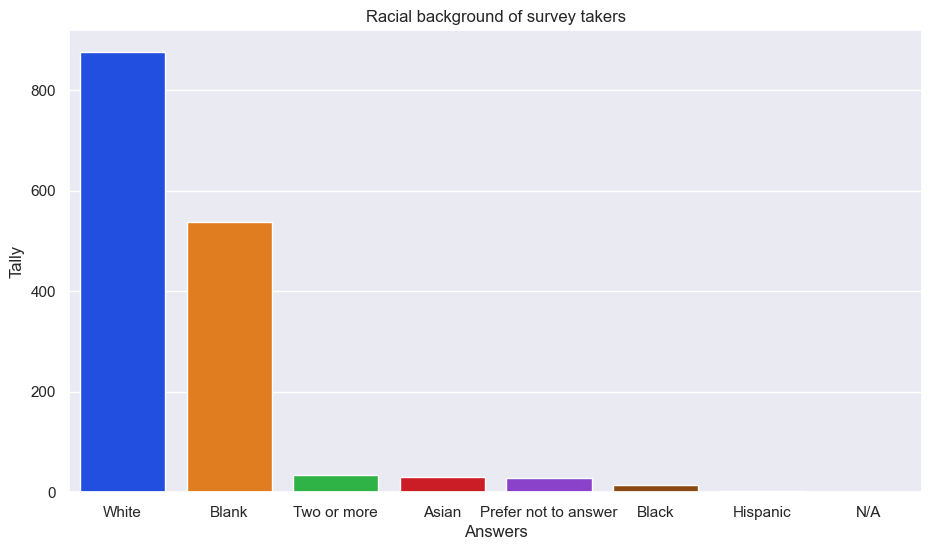

In [ ]:
race = pd.read_sql(
    "SELECT answertext Answers FROM ANSWER WHERE questionid=89",
    conn,
)
race = value_formatter(race)

# Format responses into cleaner categories
race.Answers.replace("Caucasian", "White", inplace=True)
race.Answers.replace("European American", "White", inplace=True)
race.Answers.replace("European American", "White", inplace=True)
race.Answers.replace("More than one of the above", "Two or more", inplace=True)
race.Answers.replace("White Hispanic", "Hispanic", inplace=True)
race.Answers.replace("Black or African American", "Black", inplace=True)
race.Answers.replace("I prefer not to answer", "Prefer not to answer", inplace=True)
race = value_counts_dataframe(race)

sns.barplot(race, x="Answers", y="Tally", palette=palette);
plt.title('Racial background of survey takers');

There is a very large overrepresentation of white survey takers in this dataset, which misrepresents the workforce and may be skewing our potential insights from the data in unforseen ways. 

What countries are represented across all years of the survey? 


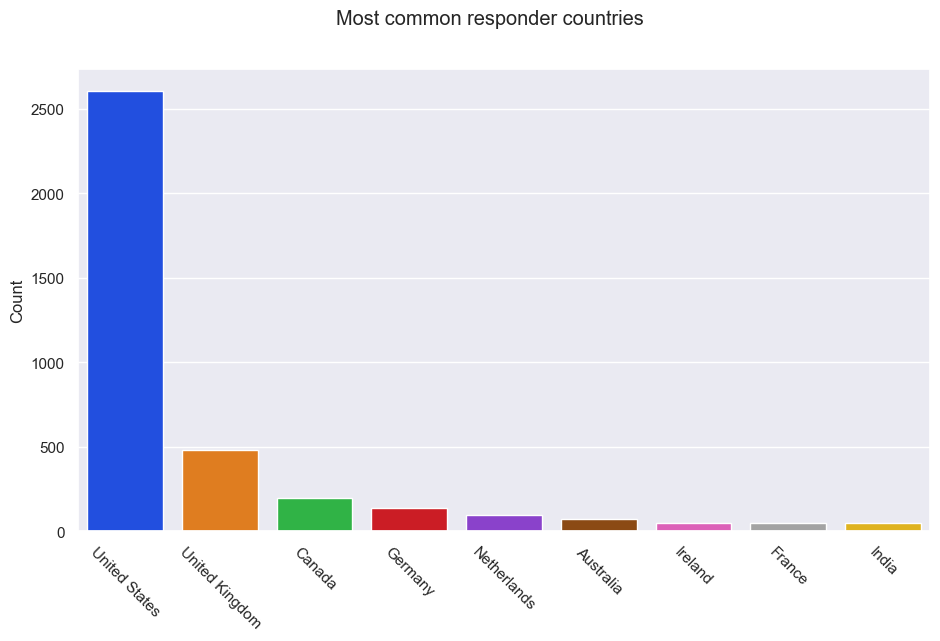

In [ ]:
# Countries represented
countries = pd.read_sql("SELECT answertext FROM ANSWER WHERE questionid=3",conn)

# Isolate top 10 countries in the survey
country_counts = (
    countries.value_counts()
    .reset_index()
    .rename(columns={"AnswerText": "Country", "count": "Count"})
)
top_10_countries = country_counts.head(10)

# Condense the United States of America and United States into one entry
top_10_countries.Count.iloc[0] = (
    top_10_countries.Count.iloc[0] + top_10_countries.Count.iloc[1]
)
top_10_countries.Country.iloc[0] = "United States"
top_10_countries.drop(index=1, inplace=True)

# Plot top 10 countries
sns.set(rc={"figure.figsize": (11, 6)})
sns.barplot(top_10_countries, x="Country", y="Count", hue="Country", palette=sns.set_palette('bright'));
plt.xticks(rotation=-45);
plt.suptitle("Most common responder countries");
plt.xlabel("");
plt.show()

What states are represented from the US across all years of the survey? 


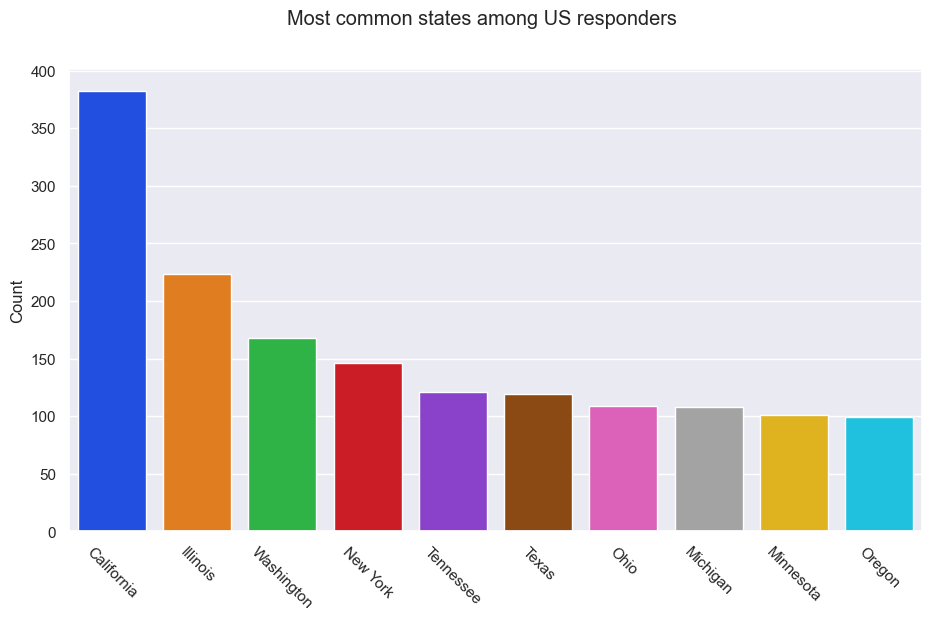

In [ ]:
# US States represented among US responders
states = pd.read_sql(
    "SELECT answertext FROM ANSWER WHERE questionid=4 AND answertext<>-1",
    conn,
)

# Tally states
state_counts = (
    states.value_counts()
    .reset_index()
    .rename(columns={"AnswerText": "State", "count": "Count"})
)
top_10_states = state_counts.head(10)

# Plot top 10 states
fig = sns.barplot(top_10_states, x="State", y="Count", hue="State");
plt.xticks(rotation=-45)
plt.suptitle("Most common states among US responders")
plt.xlabel("")
plt.show()

The US is very overrepresented in this data, and within that group California is overrepresented among other states in the country.

How many responders are there? Which year had the most responders? 

In [ ]:
pd.read_sql(
    """
SELECT 
    a.surveyid, 
    COUNT(DISTINCT a.userid) as 'Number of survey responders'
FROM 
    QUESTION as q 
INNER JOIN
    ANSWER as a 
ON 
    q.questionid = a.questionid 
WHERE 
    q.questionid=1 
GROUP BY 
    q.questiontext, 
    a.surveyid 
ORDER BY 
    a.surveyid ASC,
    COUNT(DISTINCT a.userid) DESC
""", conn)

,SurveyID,Number of survey responders
0,2014,1260
1,2016,1433
2,2017,756
3,2018,417
4,2019,352


This is a rather lopsided dimension in our dataset, which in addition to our geographic overrepresentation, will make it harder to treat our data as unbiased. Let's keep going. 

What is the size of the companies represented in the data? 

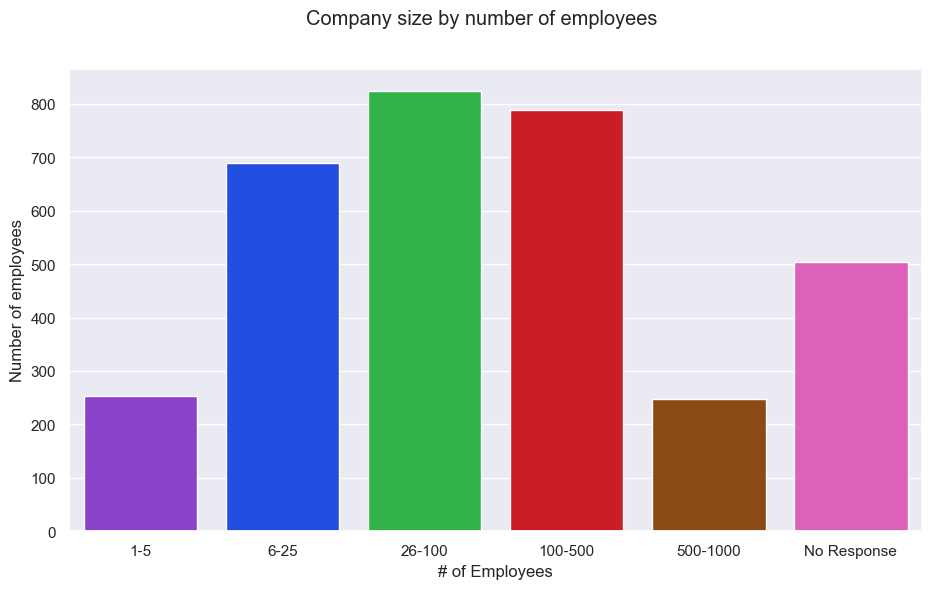

In [ ]:
company_size = answer_query(8)

# Set negative ones to n/a
company_size.AnswerText.replace("-1", "No Response", inplace=True)

# Format >1000
company_size.AnswerText.replace("More than 1000", ">1000", inplace=True)


sns.countplot(
    company_size,
    x="AnswerText",
    hue="AnswerText",
    order=["1-5", "6-25", "26-100", "100-500", "500-1000", "No Response"],
    palette=sns.set_palette("bright"),
);
plt.suptitle("Company size by number of employees")
plt.xlabel("# of Employees")
plt.ylabel("Number of employees")
plt.show()

What is the proportion of tech to non-tech companies?

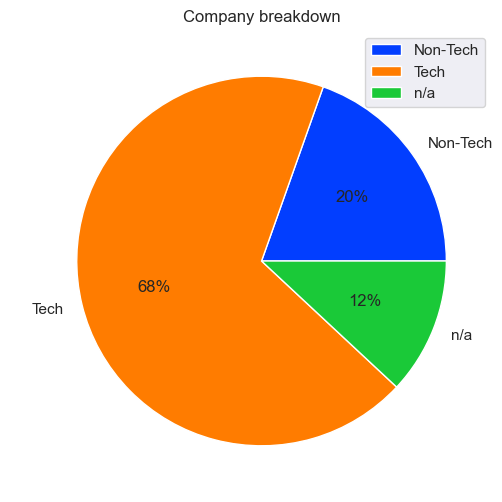

In [ ]:
# Create dataframe of answers for this question
tech_companies = answer_query(9)

# Format boolean values
tech_companies = answer_df_formatter(tech_companies, "1", "Tech")
tech_companies = answer_df_formatter(tech_companies, "0", "Non-Tech")
tech_companies = answer_df_formatter(tech_companies, "-1", "n/a")
tech_companies.AnswerText.unique()

tech_companies = value_counts_dataframe(tech_companies)
tech_companies


# Plot proportions
tech_companies.groupby(["AnswerText"]).sum().plot(
    kind="pie", y="Tally", autopct="%.0f%%"
);

plt.title("Company breakdown");
plt.ylabel(" ");

### Helper Functions 

#### answer_query

In [ ]:
def answer_query(questionid):
    """Pull answers from the answer table for the question specified.

    This function pulls all columns from answer that match a specific questionid.

    Args:
    questionid(int/str) : questionid to filter on.

    Returns:
        dataframe of query results.
    """
    questionid = str(questionid)
    query = f"SELECT * FROM ANSWER WHERE questionid={questionid}"
    df = pd.read_sql(query, conn)
    return df

#### answer_df_formatter

In [ ]:
def answer_df_formatter(df, old_value, new_value):
    """This function takes our dataframe from the answer_query helper function, and replaces a specific value for a new one"""
    df.AnswerText.replace(old_value, new_value, inplace=True)
    return df

#### value_counts_dataframe

In [ ]:
# Reformat to value counts
def value_counts_dataframe(df):
    """Returns dataframe with value counts in Tally column"""
    df=df.value_counts().reset_index().rename(columns={"count": "Tally"})
    return df

#### value_formatter

In [ ]:
def value_formatter(dataframe):
    """Overwrite values in Answers column of dataframe to be more regular."""
    # First we'll mark the -1 values as No Response
    dataframe["Answers"] = dataframe["Answers"].replace(["-1"], "Blank")

# Next we flatten all variations of Yes,_ into Yes
    mask = dataframe.Answers.str.contains("(Yes, ).*", regex=True, flags=re.IGNORECASE)
    dataframe.Answers[mask] = "Yes"

# Flatten all variation of No,_ into No
    mask=dataframe.Answers.str.contains("(No, ).*", regex=True, flags=re.IGNORECASE)
    dataframe.Answers[mask] = "No"
# Flatten the variations of maybe and not sure into maybe
    mask = dataframe.Answers.str.contains(
    "don't know|not sure|unsure|maybe", regex=True, flags=re.IGNORECASE
)
    dataframe.Answers[mask] = "Unsure"

# Group NA entries into N/A
    mask = dataframe.Answers.str.contains("NA", regex=True, flags=re.IGNORECASE)
    dataframe.Answers[mask] = "N/A"

# Some of them -> Yes
    mask = dataframe.Answers.str.contains("Some of them", regex=True, flags=re.IGNORECASE)
    dataframe.Answers[mask] = "Yes"

# None of them -> No
    mask = dataframe.Answers.str.contains("None of them", regex=True, flags=re.IGNORECASE)
    dataframe.Answers[mask] = "No"
    return dataframe

#### dataframe_assembler

In [ ]:
def dataframe_assembler(question_tuple): 
    '''Creates dataframe that designates responses as coming from either Tech or Non-Tech responders. Questions should be given as a tuple.'''
    
    query=f"SELECT questionid,answertext Answers,'Tech' as Category FROM answer WHERE questionid IN {question_tuple} AND UserID IN (SELECT DISTINCT userid FROM answer WHERE questionid=9 AND answertext=1);"
    tech = pd.read_sql(
    query,
    conn,
    )
    
    query=f"SELECT questionid,answertext Answers,'Non-tech' as Category FROM answer WHERE questionid IN {question_tuple} AND UserID IN (SELECT DISTINCT userid FROM answer WHERE questionid=9 AND answertext=0);"
    non_tech=pd.read_sql(
    query,
    conn,
    )

    # Concatenate dataframes together
    df=pd.concat([tech,non_tech],axis=0)
    df.sort_values('QuestionID',inplace=True)
    return df

#### mental_physical_plotter

In [ ]:
def mental_physical_plotter(df, mental_physical_list, title):
    '''Plot physical health and mental health questions side-by-side.
    
    Args:
        df (dataframe) : Name of dataframe
        mental_physical_list (list): list of mental and physical health question ids
        title (str) : desired title for the plot  
    
    Returns:
        none, only plots
    '''
    # Define figure
    fig, ax = plt.subplots(1, 2, figsize=(8, 6),sharey=True)
    fig.suptitle(title)
    fig.supxlabel("Tech responses")
    fig.supylabel("Percentage")

    # Tech mental plot
    sns.barplot(
        data=percentage_calculator(interview_df, mental_physical_list[0], "Tech"),
        y="percentage",
        x="Answers",
        ci=None,
        ax=ax[0],
        order=["Yes", "No", "Unsure", "Blank"],
        palette=palette,
    )

    # Tech physical plot
    sns.barplot(
        data=percentage_calculator(interview_df, mental_physical_list[1], "Tech"),
        y="percentage",
        x="Answers",
        ci=None,
        ax=ax[1],
        order=["Yes", "No", "Unsure", "Blank"],palette=palette
    )

    #Set labels and subplot titles
    ax[0].set_title("Mental health issues")
    ax[1].set_title("Physical health issues")
    ax[0].set_xlabel(" ")
    ax[0].set_ylabel(" ")

    ax[1].set_xlabel(" ")

    ax[0].set_ylabel("")
    plt.show()

    ### Non-tech plots
    fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
    fig.suptitle(title)
    fig.supxlabel("Non-tech responses")
    fig.supylabel("Percentage")

    # Tech physical plot
    sns.barplot(
        data=percentage_calculator(interview_df, mental_physical_list[0], "Non-tech"),
        y="percentage",
        x="Answers",
        ci=None,
        ax=ax[0],
        order=["Yes", "No", "Unsure", "Blank"],palette=palette
    )

    # Tech physical plot
    sns.barplot(
        data=percentage_calculator(interview_df, mental_physical_list[1], "Non-tech"),
        y="percentage",
        x="Answers",
        ci=None,
        ax=ax[1],
        order=["Yes", "No", "Unsure", "Blank"],palette=palette
    )
    ax[0].set_title("Mental health issues")
    ax[1].set_title("Physical health issues")
    ax[0].set_xlabel(" ")
    ax[0].set_ylabel(" ")

    ax[1].set_xlabel(" ")

    ax[0].set_ylabel("")


plt.show()

#### percentage_calculator

In [ ]:
def percentage_calculator(df, question, designation):
    """Calculate percentages on tech/non-tech responses for given questionid.

    Args:
        df (dataframe): desired dataframe
        question (int): questionid
        designation (string): 'Tech' or 'Non-Tech'

    Returns:
        question_subset: dataframe with responses as percentages of total
    """

    question_subset = df[
        (df["QuestionID"] == question) & (df["Category"] == designation)
    ]
    total = question_subset.Tally.sum()
    question_subset["percentage"] = question_subset.Tally.map(lambda x: x / total)

    # Order answers for easier reading
    custom_order = ["Yes", "No", "Unsure", "N/A"]

    # Convert the "Answers" column to a Categorical with the desired order
    question_subset["Answers"] = pd.Categorical(
        question_subset["Answers"], categories=custom_order, ordered=True
    )

    # Sort the DataFrame based on the custom order
    question_subset = question_subset.sort_values("Answers")
    return question_subset

#### plotter

In [ ]:
def plotter(df, question_number):
    """Plots percentages of tech and non-tech responses side by side.

    Args:
        df (dataframe): desired dataframe
        question_number(int) : questionid

    Returns:
        none, plots one figure with two subplots
    """
    question_df=pd.read_sql('SELECT * FROM question', conn)
    fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
    ax[0].set_ylabel("Percentage")
    fig.suptitle(
        (question_df[question_df.questionid == question_number].questiontext.values)[0]
    )
    fig.supxlabel(" ")

    # colors = ["#008388", "#880500"]

    for index, designation in enumerate(["Tech", "Non-tech"]):
        sns.barplot(
            data=percentage_calculator(df, question_number, designation),
            y="percentage",
            x="Answers",
            ci=None,
            ax=ax[index],
            order=["Yes", "No", "Unsure", "Blank"],
            palette=palette,
        )
        ax[index].set_title(designation)
        ax[index].set_xlabel(" ")
        ax[index].set_ylabel("Percentages")
    plt.show()

#### plot_printer

In [ ]:
def plot_printer(df, questionid):
    '''Function calls the plotter and percentage calculator functions, and prints them in an easy to read format.'''
    plotter(df,questionid)
    print(percentage_calculator(df, questionid, "Tech").head(), "\n\n")
    print(percentage_calculator(df, questionid, "Non-tech").head())

#### column_name_lister

#### null_checker

In [ ]:
# pull the columns from the databases
def column_name_lister(database):
    """Function inputs the name of the database as a string and returns a list of column names for that database"""
    all = cursor.execute(f"SELECT * FROM {database}")
    all.fetchone()
    columns = [d[0] for d in all.description]
    return columns


# use the column list from the previous function to check for null values in the database
def null_checker(columns, database):
    """Function checks each column of the database for -1 values"""
    for column in columns:
        nulls = pd.read_sql(
            f"SELECT COUNT({column}) FROM {database} WHERE {column}= -1", conn
        )
        null_count = nulls.iloc[0][0]
        print(f"{database} has {null_count} null values in {column}")

### Checking for null values

Now that we've read in the tables as dataframes, we should run queries to check for null values or duplicates. Let's write come helper functions for this here. We'll pass each of our three databases to column_name_lister and null_checker to check how many null values are in each column of each dataframe.

Now that the helper functions are defined, 

In [ ]:
db_list = ["answer", "question", "survey"]

for item in db_list:
    null_checker(column_name_lister(item), item)

answer has 56598 null values in AnswerText
answer has 0 null values in SurveyID
answer has 0 null values in UserID
answer has 0 null values in QuestionID
question has 0 null values in questiontext
question has 0 null values in questionid
survey has 0 null values in SurveyID
survey has 0 null values in Description


We have quite a few missing answers in our survey results, which could mean either that some responders didn't answer every question, or some data was lost. Let's take a closer look to see how bad this is across years.

In [ ]:
nulls_by_year_df = pd.read_sql(
    """
    SELECT 
        COUNT(CASE WHEN answertext = -1 THEN 1 END) AS null_values,
        COUNT(*) AS total_entries, 
        ROUND(COUNT(CASE WHEN answertext = -1 THEN 1 END) * 100.0/ COUNT(*),2) AS percent_null,
        surveyid 
    FROM 
        answer 
    GROUP BY 
        surveyid 
    ORDER BY 
        percent_null DESC
    """,
    conn,
)
nulls_by_year_df

,null_values,total_entries,percent_null,SurveyID
0,7966,26752,29.78,2019
1,16948,57456,29.50,2017
2,9193,31692,29.01,2018
3,20593,88238,23.34,2016
4,1898,32760,5.79,2014


With the exception of 2014, we have 23-29% missing answers in our table. We'll have to account for this later, so we should do a breakdown of null value prevalence by question by year. I'll create that dataframe in the next cell so that we can reference it later as needed.

In [ ]:
null_values_df = pd.read_sql(
"""
SELECT
    a.questionid,
    q.questiontext,
    COUNT(CASE WHEN a.answertext = -1 THEN 1 END) AS null_values,
    COUNT(DISTINCT a.userid) AS total_entries,
    ROUND(COUNT(CASE WHEN a.answertext = -1 THEN 1 END) * 100.0 / COUNT(*), 2) AS percent_null,
    surveyid
FROM
    answer a
INNER JOIN 
    question q
ON
    a.questionid=q.questionid
GROUP BY
    a.questionid, a.surveyid
ORDER BY
    percent_null DESC;
""",
    conn,
)
null_values_df.head()

,QuestionID,questiontext,null_values,total_entries,percent_null,SurveyID
0,84,Describe the circumstances of the supportive or well handled response.,756,756,100.00,2017
1,84,Describe the circumstances of the supportive or well handled response.,417,417,100.00,2018
2,84,Describe the circumstances of the supportive or well handled response.,352,352,100.00,2019
3,80,How has it affected your career?,730,756,96.56,2017
4,80,How has it affected your career?,401,417,96.16,2018


Let's see what kinds of questions have the most null values.

In [ ]:
null_values_df["questiontext"][null_values_df.percent_null > 80].unique()

array(['Describe the circumstances of the supportive or well handled response.',
       'How has it affected your career?',
       'If you have revealed a mental health disorder to a client or business contact, how has this affected you or the relationship?',
       'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?',
       'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
       'Has being identified as a person with a mental health issue affected your career?',
       'Any additional notes or comments',
       'Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?',
       'Do you know local or online resources to seek help for a mental health issue?',
       'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients

The null_values table shows that we have a few questions that are entirely, or almost entirely null values across multiple year of our survey. These questions are predominantly free form questions,
which we won't necessarily need for our analysis. We should consider if it is more expedient to consider the survey results across years, regardless of survey year in order to smooth out differences in sample size and null value rate across years. Let's look at our null values by year once again, this time calculating the overall null value rate alongside it. 

In [ ]:
print(nulls_by_year_df.head())

print(f'\nOverall null-value percentage: {nulls_by_year_df.null_values.sum() / nulls_by_year_df.total_entries.sum():.2%}')

   null_values  total_entries  percent_null  SurveyID
0         7966          26752         29.78      2019
1        16948          57456         29.50      2017
2         9193          31692         29.01      2018
3        20593          88238         23.34      2016
4         1898          32760          5.79      2014

Overall null-value percentage: 23.89%


Assessing all of the years together brings our overall null_value rate down to 23.89%, and also works for our research questions. From here on out we'll treat the survey years as a single dataset.

# Analysis

In this section we'll gauge the survey'seffectiveness in answering the 4 research questions that we'd like to prioritize. We'll pull relevant questions and assess our ability to answer these questions currently.

## Research question #1
### Are tech workers more likely than other workers to have mental health problems? 


To answer this question, we need to consider patients that currently have, or previously have had a mental health disorders. I've isolated those questions here, which we will query responses for, as well as for question 9, which designates the responders place of employment as a tech company or not. These questions are listed in the cell below.

In [ ]:
pd.read_sql(
    """
SELECT 
    DISTINCT questiontext, 
    questionid
FROM 
    QUESTION 
WHERE 
    questionid IN (6,7,9,32,33,34)
""",
    conn,
)

,questiontext,questionid
0,Do you have a family history of mental illness?,6
1,Have you ever sought treatment for a mental health disorder from a mental health professional?,7
2,Is your employer primarily a tech company/organization?,9
3,Have you had a mental health disorder in the past?,32
4,Do you currently have a mental health disorder?,33
5,Have you ever been diagnosed with a mental health disorder?,34


We'll create 2 dataframes to differentiate tech and non-tech companies.

In [ ]:
tech_df = pd.read_sql(
    "SELECT answertext, questionid,userid FROM answer WHERE questionid IN (6,7,32,33,34) AND userid IN (SELECT userid FROM answer WHERE questionid=9 AND answertext=1)",
    conn,
)


non_tech_df = pd.read_sql(
    "SELECT answertext, questionid,userid FROM answer WHERE questionid IN (6,7,32,33,34) AND userid NOT IN (SELECT userid FROM answer WHERE questionid=9 AND answertext=1)",
    conn,
)

Do you have a family history of mental illness?


In [ ]:
df1 = tech_df[tech_df.QuestionID == 6].copy()
df1 = value_counts_dataframe(df1)
#Q6_df = pd.pivot_table(df1, values="count", columns="AnswerText", aggfunc="count", fill_value=0)
df1.index
df1

,AnswerText,QuestionID,UserID,Tally
0,I don't know,6,1271,1
1,Yes,6,946,1
2,Yes,6,954,1
3,Yes,6,956,1
4,Yes,6,958,1
...,...,...,...,...
2883,No,6,1113,1
2884,No,6,1116,1
2885,No,6,1117,1
2886,No,6,1120,1


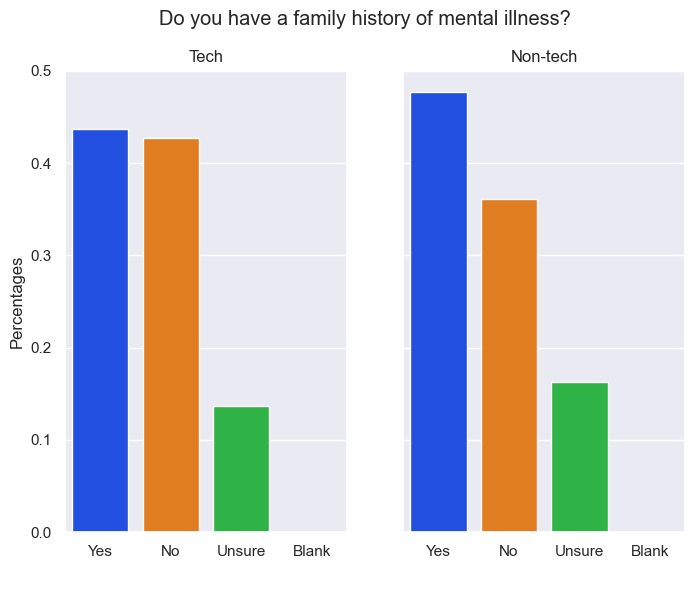

   QuestionID Answers Category  Tally  percentage
0           6     Yes     Tech   1261    0.436634
1           6      No     Tech   1232    0.426593
2           6  Unsure     Tech    395    0.136773 


   QuestionID Answers  Category  Tally  percentage
3           6     Yes  Non-tech    394    0.476998
4           6      No  Non-tech    298    0.360775
5           6  Unsure  Non-tech    134    0.162228


In [ ]:
# Pull question 6 results
family_history_df = dataframe_assembler("(6)")

# Clean values
family_history_df = value_formatter(family_history_df)

# Transform to value_counts
family_history_df = value_counts_dataframe(family_history_df)

# Plot
plot_printer(family_history_df, 6)

Here we can see that the tech community is on par with the larger talent pool based on the prevalence of mental disorders. Next let's take a look the distribution of patients that currently have a mental disorder or have had one in the past. 

Interestingly, the lines for all 3 of these categories has been decreasing each year in both graphs, but it is important to note that the sample size is much smaller for non-tech workers given that we have a 68% tech worker dataset. To build out a more complete view of mental health history, we'll also dive into question 34.

#### Have you ever been diagnosed with a mental health disorder?

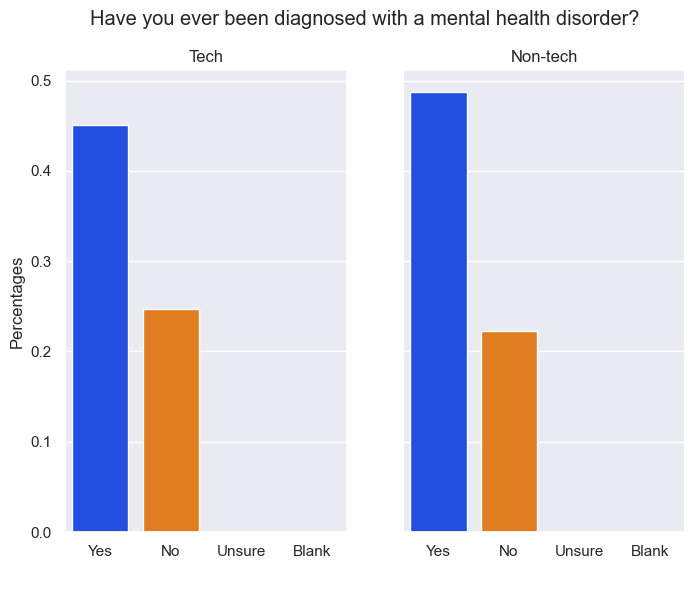

   QuestionID Answers Category  Tally  percentage
0          34     Yes     Tech    837    0.450727
2          34      No     Tech    458    0.246634
1          34     NaN     Tech    562    0.302639 


   QuestionID Answers  Category  Tally  percentage
3          34     Yes  Non-tech    291    0.487437
5          34      No  Non-tech    133    0.222781
4          34     NaN  Non-tech    173    0.289782


In [ ]:
# Pull question 6 results
family_history_df = dataframe_assembler("(34)")

# Clean values
family_history_df = value_formatter(family_history_df)

# Transform to value_counts
family_history_df = value_counts_dataframe(family_history_df)

# Plot
plot_printer(family_history_df, 34)

This graph produces a similar graphs to the previous question about mental health family histories across the population. From this breakdown of the data we have a available here, we can conclude that our data doesn't point to any discernible difference between tech workers within the general population. We should proceed though and see how these worker populations behave in terms of seeking help when mental health difficulties present themselves.

## Research question #2
### Do tech workers have mental health resources available, and if so do they use them? 


We will use the following questions from the survey to answer this research question since they speak to both the availability, and likelihood that workers pursue mental health options tied to their employment. 

In [ ]:
pd.read_sql(
    """
            SELECT 
                DISTINCT questiontext,questionid
            FROM question 
            WHERE questionid 
                IN ('10','14','18','19','31')
            """,
    conn,
).set_index("questionid")

,questiontext
questionid,
10,Does your employer provide mental health benefits as part of healthcare coverage?
14,Do you know the options for mental health care available under your employer-provided health coverage?
18,Would you feel comfortable discussing a mental health issue with your coworkers?
19,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?
31,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?


Let's look at our answers to this set of questions, though they are phrased as yes/no questions, we could still receive a variety of answers back, especially if the survey field was free form.

In [ ]:
# Check if these answers need to be formatted before we create visualizations from them.
pd.read_sql(
    """
    SELECT 
        DISTINCT answertext Answers,
        questionid
    FROM 
        answer
    WHERE questionid IN ('10','14','18','19','31');""",
    conn,
)

,Answers,QuestionID
0,Yes,10
1,Don't know,10
2,No,10
3,Not eligible for coverage / NA,10
4,-1,10
5,I don't know,10
6,-1,14
7,Yes,14
8,I am not sure,14
9,No,14


Here we can see that the responses will need some standardization, so let's start there. We'll query these questions again, along with a designator of whether the responses come from tech or non-tech workers, and then we'll concatenate those two to create an overall dataframe. 

In [ ]:
# Tech df
df1 = pd.read_sql(
    """
    SELECT 
        answertext Answers,
        questionid,
        'Tech' as Category
    FROM 
        answer
    WHERE questionid IN ('10','14','18','19','31')
    AND 
        UserID IN (SELECT DISTINCT userid FROM answer WHERE questionid=9 AND answertext=1);
    """,
    conn,
)

# non-tech
df2 = pd.read_sql(
    """
    SELECT 
        answertext Answers,
        questionid,
        'Non-tech' as Category
    FROM 
        answer
    WHERE questionid IN ('10','14','18','19','31')
    AND 
        UserID IN (SELECT DISTINCT userid FROM answer WHERE questionid=9 AND answertext=0);
    """,
    conn,
)


# Concatenate dataframes together
RQ2_df=pd.concat([df1,df2],axis=0)
RQ2_df.sort_values('QuestionID',inplace=True)
RQ2_df

,Answers,QuestionID,Category
0,Yes,10,Tech
271,I don't know,10,Non-tech
270,Yes,10,Non-tech
269,No,10,Non-tech
268,No,10,Non-tech
...,...,...,...
4946,-1,31,Tech
4945,-1,31,Tech
4944,-1,31,Tech
4956,-1,31,Tech


Now let's format RQ2_df so that our answers make more sense

In [ ]:
RQ2_df=value_formatter(RQ2_df)
RQ2_df.Answers.unique()

array(['Yes', 'Unsure', 'No', 'N/A', 'Blank'], dtype=object)

Now that we've standardized the answer values in our Research Question 2 dataframe, let's generate value counts of responses corresponding to the each question.

In [ ]:
RQ2_df = value_counts_dataframe(RQ2_df)
RQ2_df.sort_values(by=["QuestionID", "Answers"], inplace=True)

Next, we'll subset the dataframe on questions
10, 14, 18, 19, and 31. For each question, we'll calculate the percentage of responses of Yeses, Nos,etc., updating the percentage column to reflect that number.we'll use our percentage_calculator helper function for that.

### Access
Now that we've defined our functions, let's look at questions 10 and 14 together since they pertain to the availability of employment-tied healthcare, and the employees knowledge of their options.

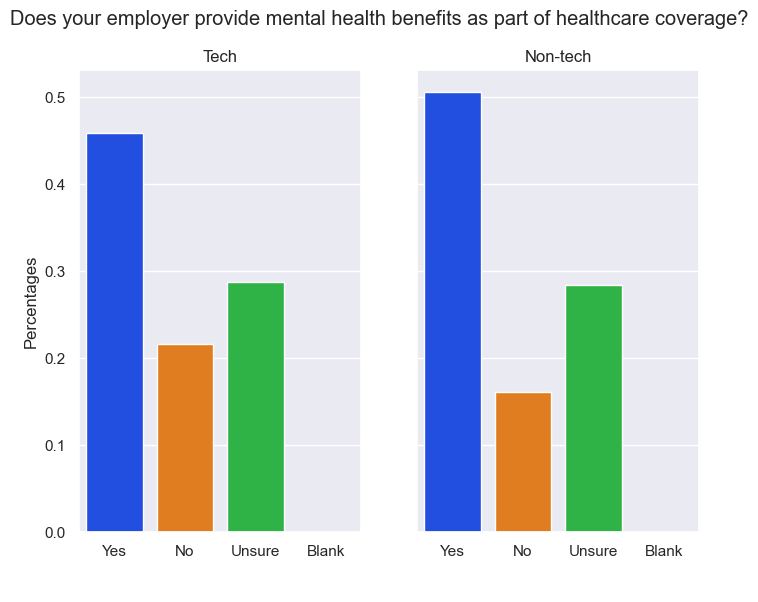

   Answers  QuestionID Category  Tally  percentage
0      Yes          10     Tech   1326    0.459141
9       No          10     Tech    623    0.215720
1   Unsure          10     Tech    831    0.287742
30     N/A          10     Tech    108    0.037396 


   Answers  QuestionID  Category  Tally  percentage
13     Yes          10  Non-tech    418    0.506053
28      No          10  Non-tech    133    0.161017
18  Unsure          10  Non-tech    235    0.284504
35     N/A          10  Non-tech     40    0.048426


In [ ]:
plot_printer(RQ2_df,10)

These two groups follow the same distribution of responses between both populations, even though the tech contingent is much bigger.

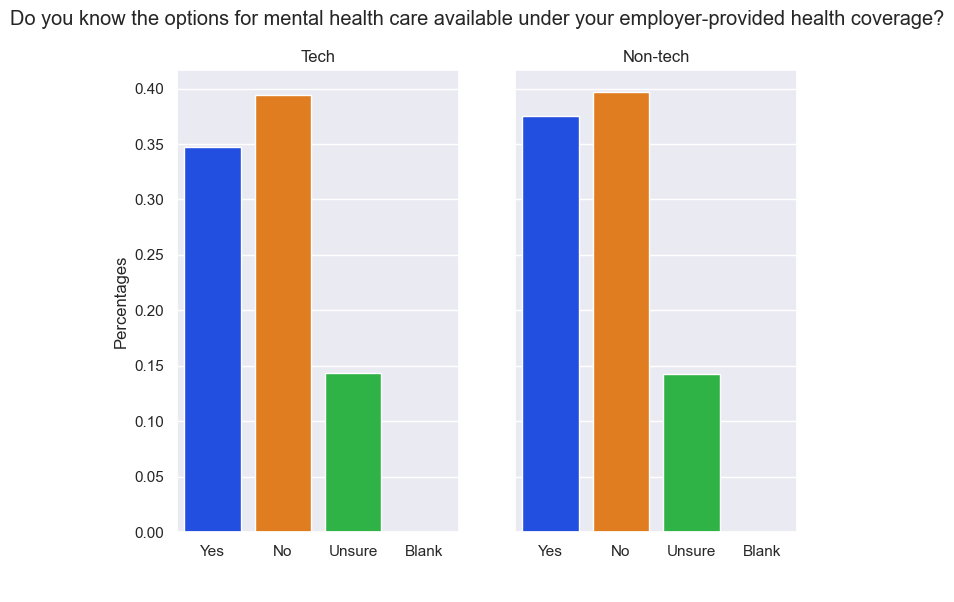

   Answers  QuestionID Category  Tally  percentage
7      Yes          14     Tech    645    0.347334
3       No          14     Tech    733    0.394723
15  Unsure          14     Tech    267    0.143780
22     NaN          14     Tech    212    0.114163 


   Answers  QuestionID  Category  Tally  percentage
21     Yes          14  Non-tech    224    0.375209
17      No          14  Non-tech    237    0.396985
33  Unsure          14  Non-tech     85    0.142379
34     NaN          14  Non-tech     51    0.085427


In [ ]:
plot_printer(RQ2_df,14)

### Social environment
We can see here that our percentages for these two are similarly broken up, with most people not being aware of their options in this regard. Together these questions point to respondents, regardless of their place of employment, knowing that they have mental health provisions under their employment contract, but not knowing the specifics of how they work or how to access them. Let's dig into the next few questions to see how they feel talking about or disclosing mental health issues in the workplace.

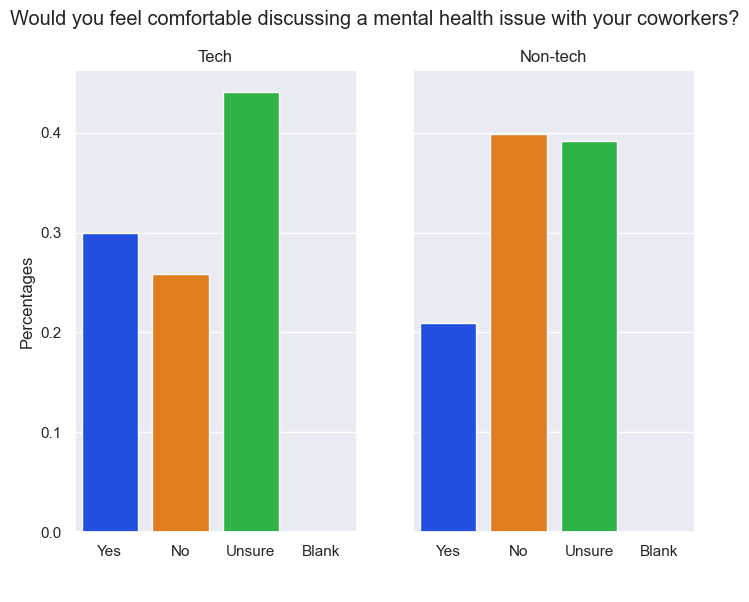

   Answers  QuestionID Category  Tally  percentage
10     Yes          18     Tech    557    0.299946
12      No          18     Tech    481    0.259020
2   Unsure          18     Tech    819    0.441034 


   Answers  QuestionID  Category  Tally  percentage
29     Yes          18  Non-tech    125     0.20938
16      No          18  Non-tech    238     0.39866
19  Unsure          18  Non-tech    234     0.39196


In [ ]:
plot_printer(RQ2_df,18)

This is the first dimension in this section where we've seen where survey takers differed from each other--Tech workers are more likely to respond unsure than their non-tech counterparts, and non-tech workers are much more likely to say no. This could be a factor of age, differences in work culture at tech companies vs others, or other features not captured here. This could difference in groups could also be partially accounted for by gender since our survey takers are overwhelmingly male.  

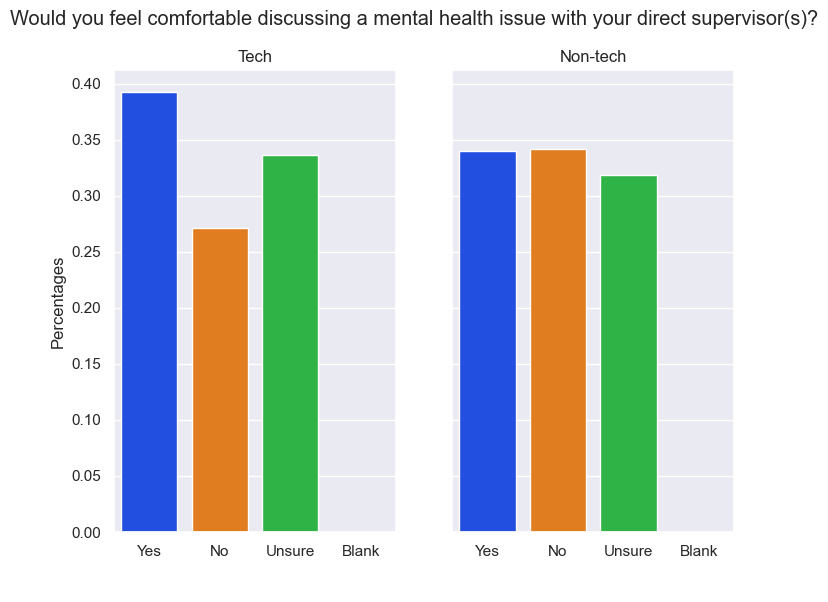

   Answers  QuestionID Category  Tally  percentage
4      Yes          19     Tech    729    0.392569
11      No          19     Tech    503    0.270867
8   Unsure          19     Tech    625    0.336564 


   Answers  QuestionID  Category  Tally  percentage
25     Yes          19  Non-tech    203    0.340034
24      No          19  Non-tech    204    0.341709
27  Unsure          19  Non-tech    190    0.318258


In [ ]:
plot_printer(RQ2_df,19)

A higher proportion of tech workers responded yes to this question, but the responses were pretty evenly spread for both groups. We'd need more data to believe this outcome more strongly. 

## Research Question #3: 

1. Worker Privacy: Do workers trust that their privacy will be protected? <br><br>
2. Career Reprisals: Do they fear career reprisals?



### Worker Privacy

In [ ]:
privacy_df=dataframe_assembler((11,27))
# Our responses to these two questions need to be cleaned up a little bit, so I'm going to pass our helper function for formatting before we proceed. 

# Format values for easier visualization
privacy_df = value_formatter(privacy_df)

# Transform to value_counts
privacy_df = value_counts_dataframe(privacy_df)
privacy_df

,QuestionID,Answers,Category,Tally
0,11,Unsure,Tech,1862
1,27,Unsure,Tech,1068
2,11,Yes,Tech,862
3,11,Unsure,Non-tech,504
4,27,Unsure,Non-tech,363
5,11,Yes,Non-tech,273
6,27,Yes,Tech,257
7,27,Blank,Tech,225
8,27,Sometimes,Tech,167
9,11,No,Tech,164


Now we can plot the two responses and look at what the data tells us.

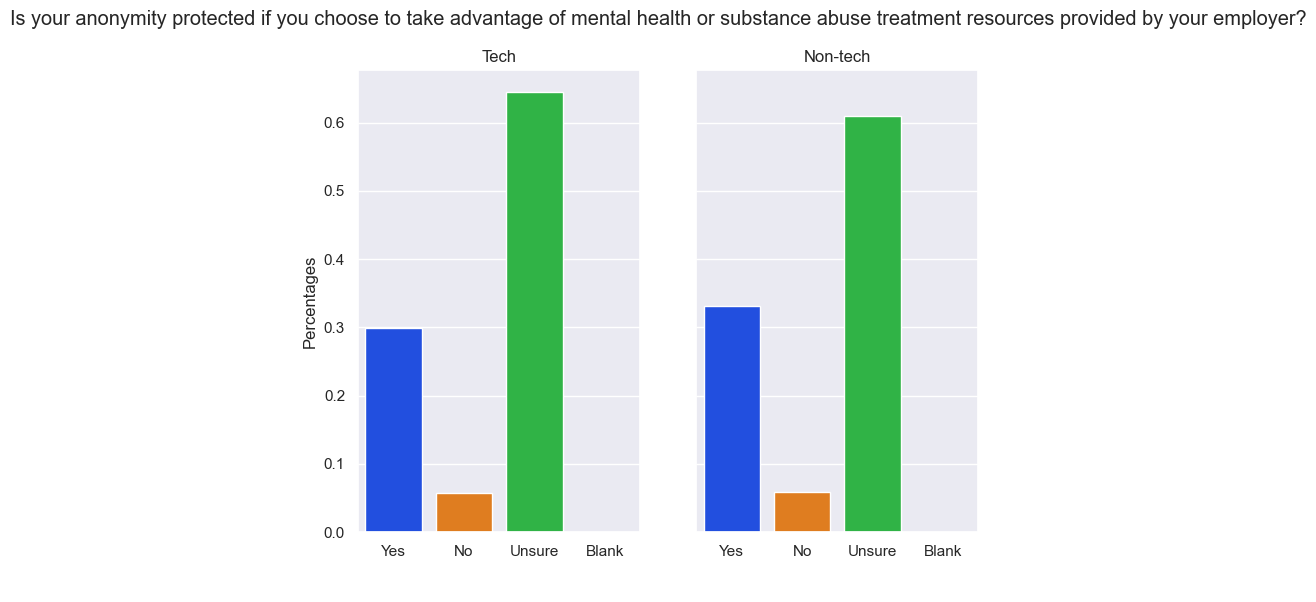

   QuestionID Answers Category  Tally  percentage
2          11     Yes     Tech    862    0.298476
9          11      No     Tech    164    0.056787
0          11  Unsure     Tech   1862    0.644737 


    QuestionID Answers  Category  Tally  percentage
5           11     Yes  Non-tech    273    0.330508
13          11      No  Non-tech     49    0.059322
3           11  Unsure  Non-tech    504    0.610169


In [ ]:
# Create the plots for our two categories for question 11
plot_printer(privacy_df,11)

On this question, the tech and non-tech populations mirror each other, with almost identical proportions given for this answer. This seems to responses being a more general commentary on work culture, more specifically US work culture. Let's see how things look on the next question.

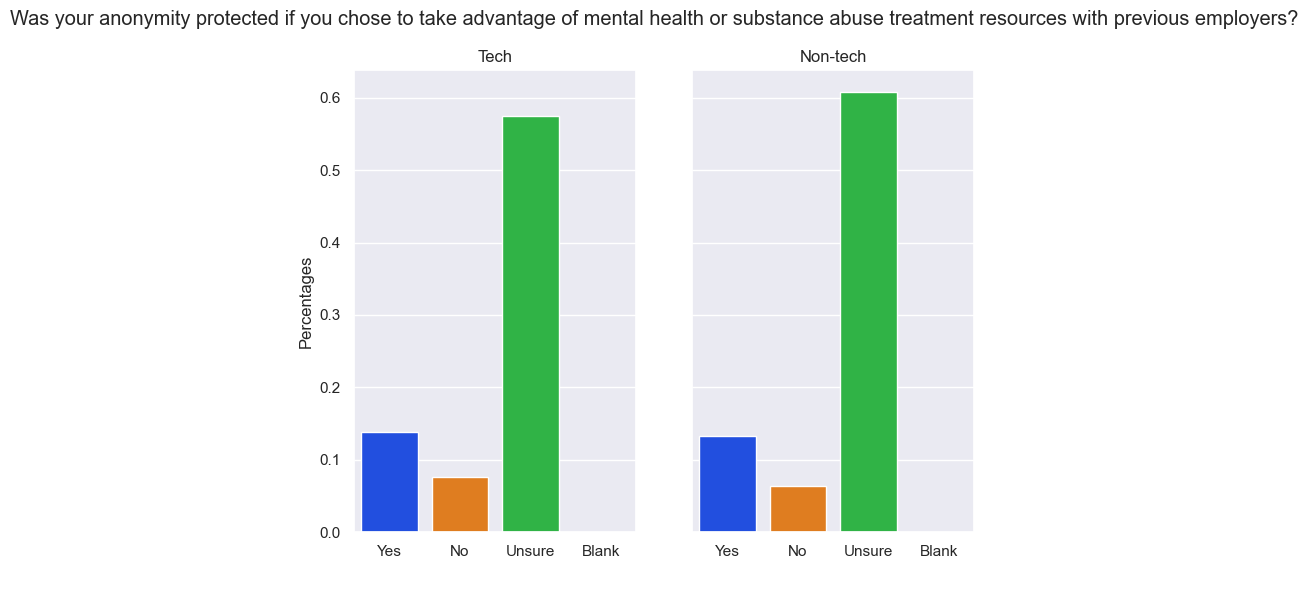

    QuestionID Answers Category  Tally  percentage
6           27     Yes     Tech    257    0.138395
10          27      No     Tech    140    0.075390
1           27  Unsure     Tech   1068    0.575121
7           27     NaN     Tech    225    0.121163
8           27     NaN     Tech    167    0.089930 


    QuestionID Answers  Category  Tally  percentage
12          27     Yes  Non-tech     79    0.132328
14          27      No  Non-tech     38    0.063652
4           27  Unsure  Non-tech    363    0.608040
11          27     NaN  Non-tech     85    0.142379
15          27     NaN  Non-tech     32    0.053601


In [ ]:
plot_printer(privacy_df,27)

This question behaves similarly to the previous one. We'd need to break this question down further to get information on what dangers to anonymity are/were present in the responder's minds so that we could get more information out of this. Let's look at the risk of career reprisals.

### Career Reprisals

In this section we'll look at question pertaining to perceptions of negative effects on one's career in both previous and current places of employment

In [ ]:
#Assemble a dataframe of relevant questions
reprisals_df=dataframe_assembler((108,109,112,113))

# Format values for easier visualization
reprisals_df = value_formatter(reprisals_df)

# Transform to value_counts
reprisals_df = value_counts_dataframe(reprisals_df)

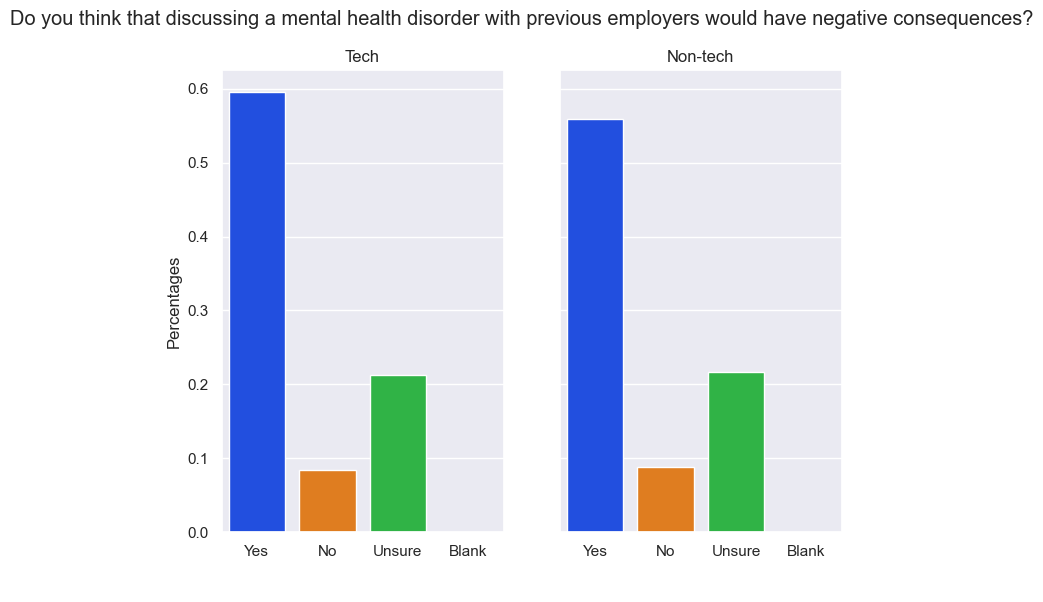

    QuestionID Answers Category  Tally  percentage
0          108     Yes     Tech    526    0.595696
19         108      No     Tech     74    0.083805
7          108  Unsure     Tech    188    0.212911
17         108     NaN     Tech     95    0.107588 


    QuestionID Answers  Category  Tally  percentage
8          108     Yes  Non-tech    147    0.558935
25         108      No  Non-tech     23    0.087452
20         108  Unsure  Non-tech     57    0.216730
23         108     NaN  Non-tech     36    0.136882


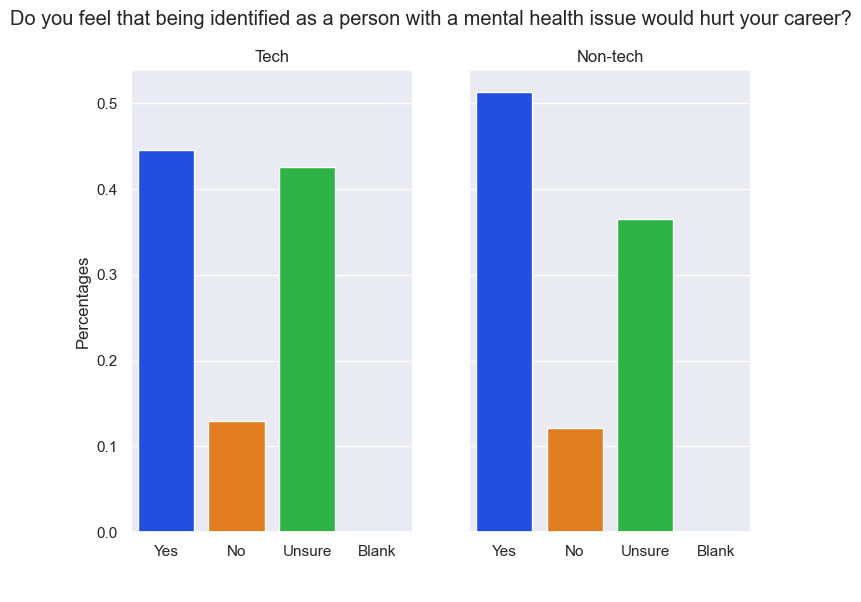

    QuestionID Answers Category  Tally  percentage
3          113     Yes     Tech    393    0.445074
12         113      No     Tech    114    0.129105
4          113  Unsure     Tech    376    0.425821 


    QuestionID Answers  Category  Tally  percentage
10         113     Yes  Non-tech    135    0.513308
24         113      No  Non-tech     32    0.121673
14         113  Unsure  Non-tech     96    0.365019


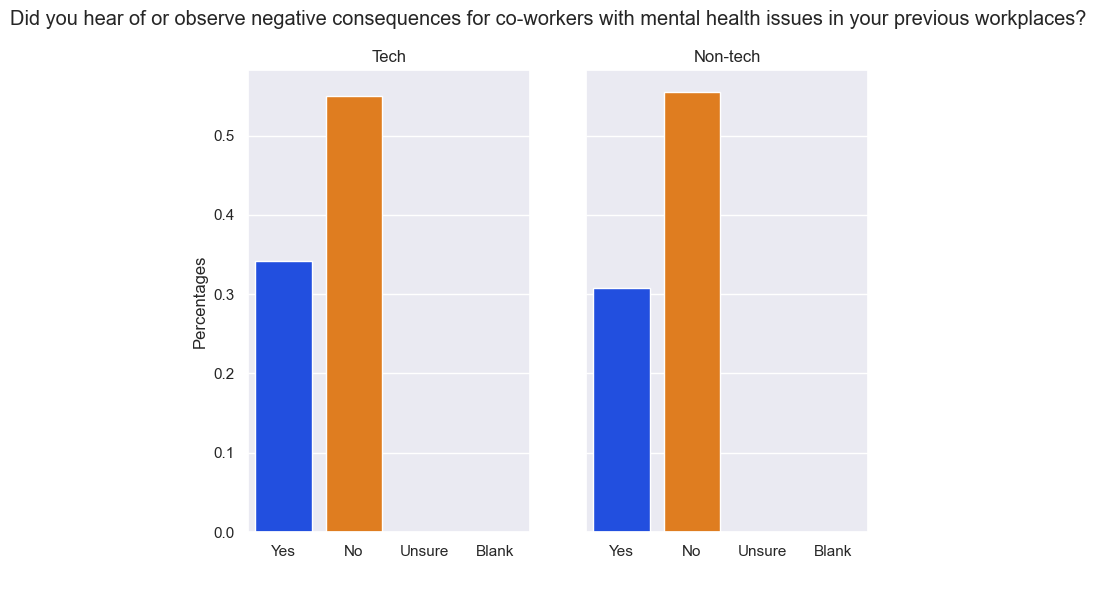

    QuestionID Answers Category  Tally  percentage
6          112     Yes     Tech    302    0.342016
1          112      No     Tech    486    0.550396
15         112     NaN     Tech     95    0.107588 


    QuestionID Answers  Category  Tally  percentage
18         112     Yes  Non-tech     81    0.307985
9          112      No  Non-tech    146    0.555133
21         112     NaN  Non-tech     36    0.136882


In [ ]:
plot_printer(reprisals_df, 108)
plot_printer(reprisals_df, 113)
plot_printer(reprisals_df, 112)

Survey takers in both groups are likely to believe that disclosing a mental health disorder in their previous job would have had negative consequences, and also are more likely to believe that having a mental health disorder would hurt their careers. Interestingly, not as many responders have witnessed negative consequences for coworkers with mental health issues in the past, which points to their responses here being more about their perception than experiences in most cases. Considering that many also responded that they could discuss mental health issues with their manager/supervisor, these responses point to fear of negative consequences in the larger company, which would need to be explored further. Let's take a look at how mental health and physical health are viewed relative to one another in Research Question 4.

## Research Question 4:
### Physical vs. Mental Health
Do survey takers feel that mental health is valued relative to physical health health in their workplace? 


First we'll consider the proportions of responders that feel that mental health and physical health are given equal consideration in their workplace. 

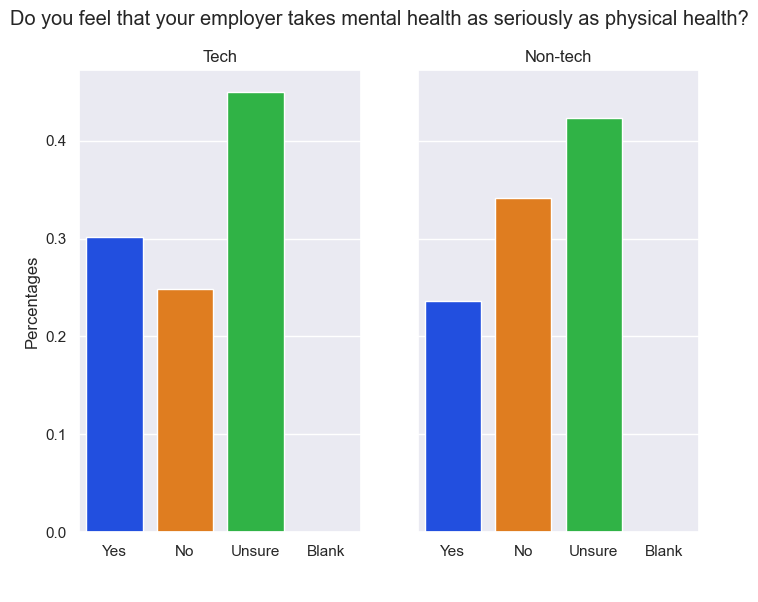

   QuestionID Answers Category  Tally  percentage
1          91     Yes     Tech    577    0.301463
2          91      No     Tech    476    0.248694
0          91  Unsure     Tech    861    0.449843 


   QuestionID Answers  Category  Tally  percentage
5          91     Yes  Non-tech    116    0.235772
4          91      No  Non-tech    168    0.341463
3          91  Unsure  Non-tech    208    0.422764


In [ ]:
health_comparison_df = dataframe_assembler("(91)")

# Format values for easier visualization
health_comparison_df = value_formatter(health_comparison_df)

# Transform to value_counts
health_comparison_df = value_counts_dataframe(health_comparison_df)

plot_printer(health_comparison_df, 91)

Here we can see that tech workers are slightly more likely to say yes, and are slighly less likely to say no to this question. We would need more data to not only see how strong a difference this really is between these groups but also how dependent on the composition of non-tech industries this difference is. Let's look at how comfortable responders would feel disclosing their health status during an interview in order to hopefully answer our question from another angle.  

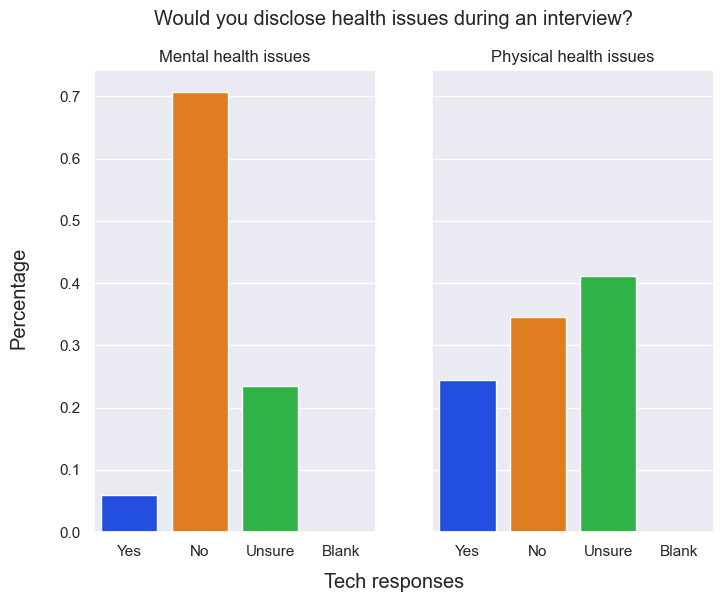

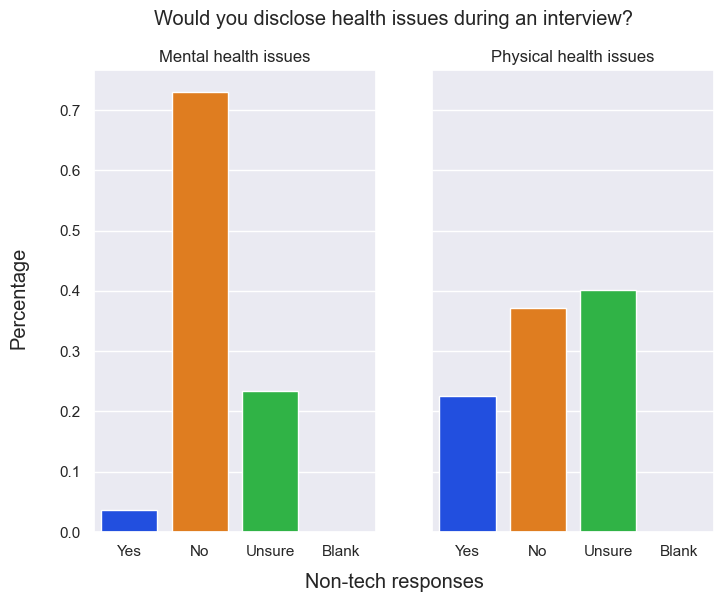

In [ ]:
interview_df=dataframe_assembler((12,29))

# Format values for easier visualization
interview_df = value_formatter(interview_df)

# Transform to value_counts
interview_df = value_counts_dataframe(interview_df)
interview_df.sort_values(by=['QuestionID', 'Answers'])
mental_physical_plotter(interview_df,[12,29],"Would you disclose health issues during an interview?")

Though the two graphs are distributed similarly across non-tech and tech groups, survey takers appear to be equally resistant to disclosing health status of any kind during interviews. So how does this translate to the survey taker's current employer? 

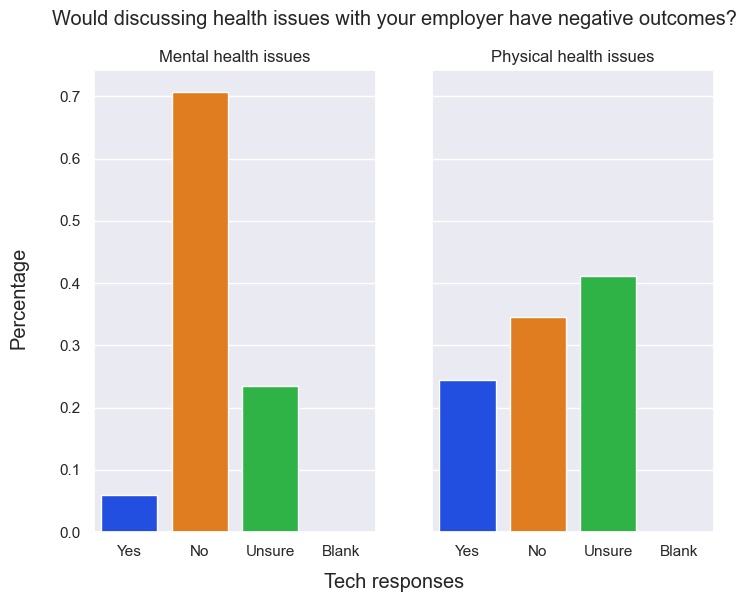

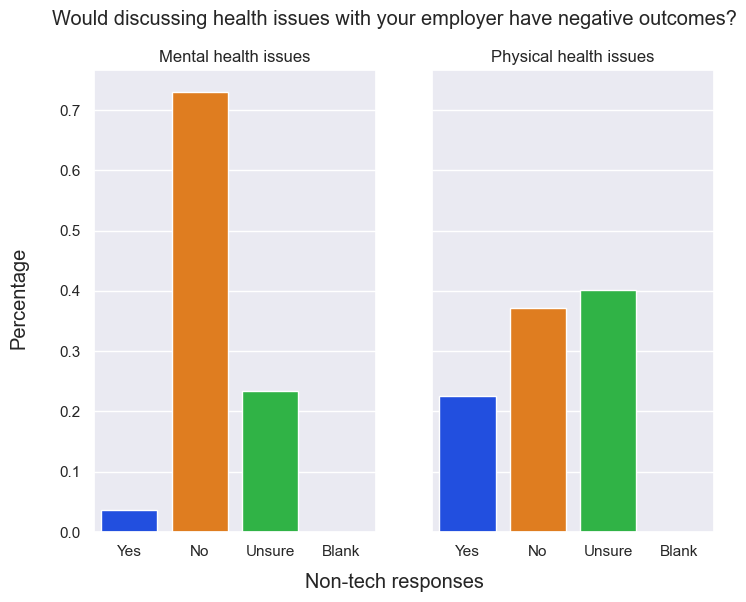

In [ ]:
employer_df = dataframe_assembler((12, 29))

# Format values for easier visualization
employer_df = value_formatter(employer_df)

# Transform to value_counts
employer_df = value_counts_dataframe(employer_df)
employer_df.sort_values(by=["QuestionID", "Answers"])


mental_physical_plotter(
    employer_df, [12, 29], "Would discussing health issues with your employer have negative outcomes?"
)

Survey responders in both groups believe that negative outcomes are less likely when discussing their mental health issues with their employers compared to their physical health. The responses to this question may be at odds with our previous questions about whether responders feel comfortable disclosing mental health issues to coworkers, so it would be helpful to have questions oriented toward specific,possible negative outcomes in order to clarify our qualitative data here. 

# Conclusions
Going through the survey questions corresponding to these 4 research questions, we can see that we are only able to glean incomplete insights from our current survey data, do to the structure of the survey and the biased nature of our sampling. These two features will have to be fixed before relaunching the survey this year. 

# Recommendations
1. Previous survey years were too biased, and need to be reworked to more accurately represent worker pools in both tech and non-tech industries
     - United States is overrepresented, as is California
     - White workers are overrepresented, as are men
     - Tech companies are overrepresented, and it is unclear what kinds of non-tech companies are being included. <br><br>
2. Questions need to be worded better to decouple sentiments toward working, managerial concerns, and professional/social worries.<br><br>
3. Questions need to be introduced to capture remote and hybrid work as well as traditional, in-office work.<br><br>
4. "Tech worker" needs to be defined for the purposes of this survey<br>
     - Are contract workers and full-time workers considered equally?<br>
     - Are both technical and non-technical roles sampled equally?<br>
     - What non-tech industries are being used as analogues? <br>